##  import など

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display,HTML,Image
import re

In [6]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')#Stopwods辞書
nltk.download('wordnet')#Lemmatization用。
nltk.download('punkt')#適切に単語分割してくれるTokenizer
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macico/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/macico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macico/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [64]:
import gensim
from gensim import corpora
from gensim.corpora import Dictionary


### 便利フォーマットなど

In [9]:
%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

## 役立つリンク集
- https://hibiki-press.tech/learn_prog/python/format/1015#format
- https://qiita.com/NTeTN/items/ae973bfedfff248e4de6

# 下準備

In [10]:
read_file = "./data/AB_NYC_2019.csv"

In [11]:
df = pd.read_csv(read_file)

In [12]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,nan,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [13]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [14]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## 欠損値補完

### Name

- 緯度と経度が同じであるとNameは一緒であるとみた

In [15]:
df[df.name.isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2854,1615764,NaN,6676776,Peter,Manhattan,Battery Park City,40.71,-74.02,Entire home/apt,400,1000,0,NaN,nan,1,362
3703,2232600,NaN,11395220,Anna,Manhattan,East Village,40.73,-73.99,Entire home/apt,200,1,28,2015-06-08,0.45,1,341
5775,4209595,NaN,20700823,Jesse,Manhattan,Greenwich Village,40.73,-73.99,Entire home/apt,225,1,1,2015-01-01,0.02,1,0
5975,4370230,NaN,22686810,Michaël,Manhattan,Nolita,40.72,-74.00,Entire home/apt,215,7,5,2016-01-02,0.09,1,0
6269,4581788,NaN,21600904,Lucie,Brooklyn,Williamsburg,40.71,-73.94,Private room,150,1,0,NaN,nan,1,0
6567,4756856,NaN,1832442,Carolina,Brooklyn,Bushwick,40.70,-73.93,Private room,70,1,0,NaN,nan,1,0
6605,4774658,NaN,24625694,Josh,Manhattan,Washington Heights,40.85,-73.93,Private room,40,1,0,NaN,nan,1,0
8841,6782407,NaN,31147528,Huei-Yin,Brooklyn,Williamsburg,40.71,-73.94,Private room,45,1,0,NaN,nan,1,0
11963,9325951,NaN,33377685,Jonathan,Manhattan,Hell's Kitchen,40.76,-73.99,Entire home/apt,190,4,1,2016-01-05,0.02,1,0
12824,9787590,NaN,50448556,Miguel,Manhattan,Harlem,40.80,-73.95,Entire home/apt,300,5,0,NaN,nan,5,0


In [16]:
pd.DataFrame(df[df.name.isnull()].groupby(['latitude','longitude']).count()['id'])

id
latitude longitude    
40.66    -73.92      1
40.69    -73.93      1
40.70    -73.93      1
         -73.93      1
40.71    -74.02      1
         -73.94      1
         -73.94      1
40.72    -73.99      1
         -74.00      1
40.73    -73.99      1
         -73.99      1
40.76    -73.99      1
40.80    -73.96      1
         -73.95      1
40.85    -73.93      1
40.86    -73.88      1

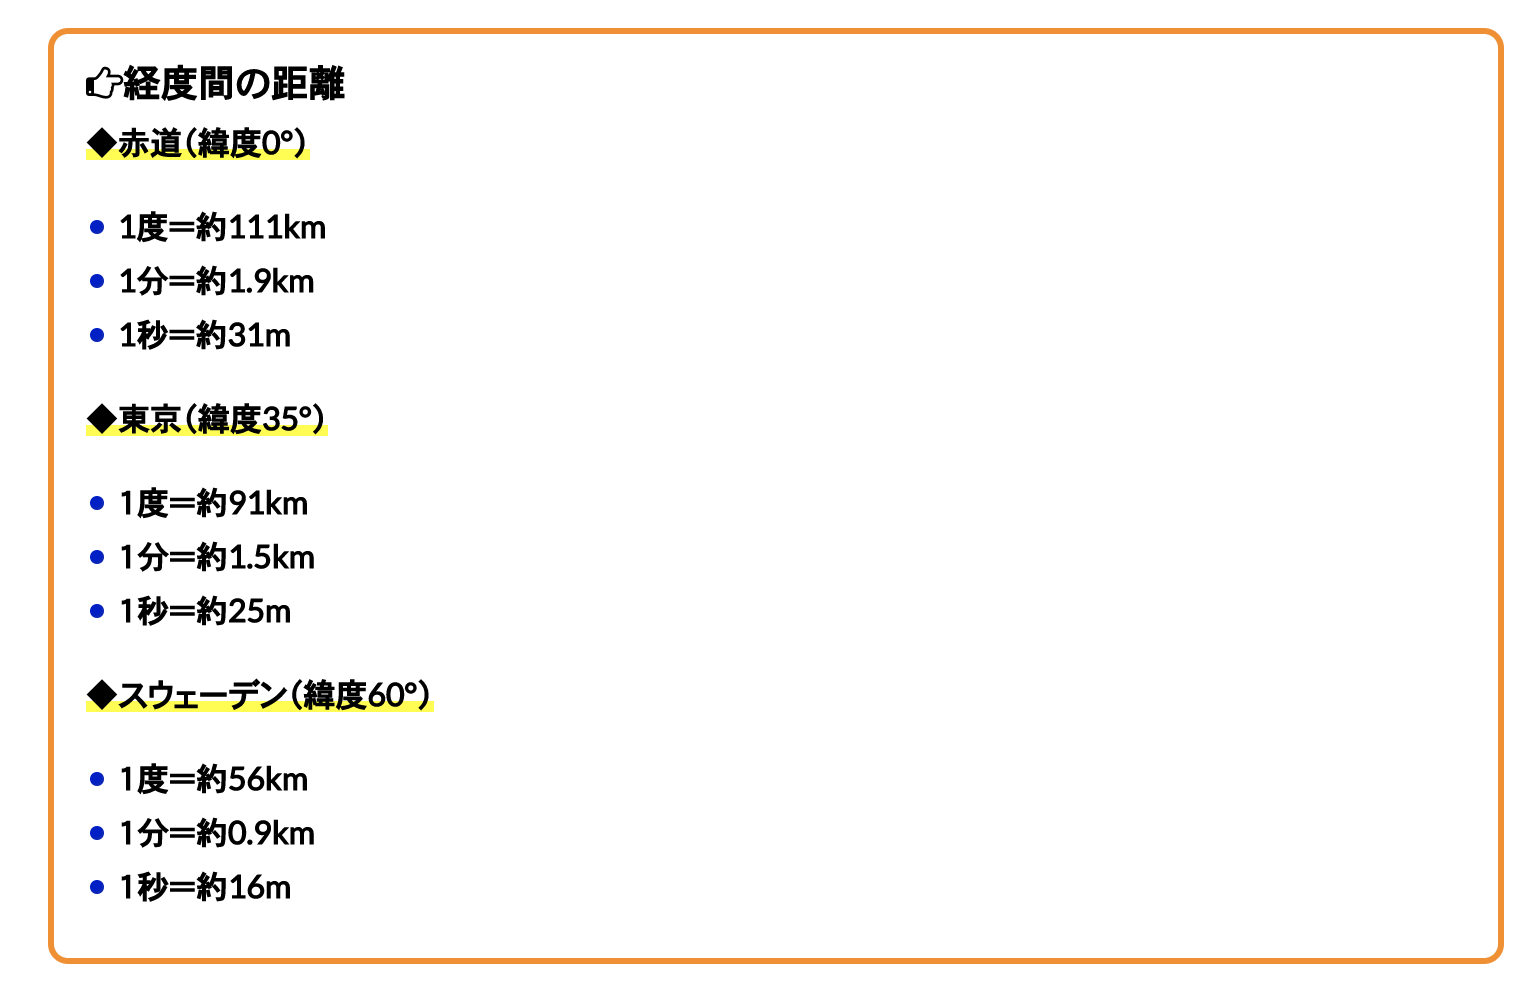

In [17]:
Image('./markdown/LatitudeLongitude.png')

- なので、一見同じでも、現在の表示上は異なる

- 名前はユニークに保管

In [18]:
df.loc[df.name.isnull(),'name'] = pd.Series([ 'name_'+str(_i) for _i in range(len(df.name.isnull()))])

### host name
- Nameと同様の処理を行なう

In [19]:
df[df.host_name.isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
360,100184,Bienvenue,526653,NaN,Queens,Queens Village,40.72,-73.76,Private room,50,1,43,2019-07-08,0.45,1,88
2700,1449546,Cozy Studio in Flatbush,7779204,NaN,Brooklyn,Flatbush,40.65,-73.96,Entire home/apt,100,30,49,2017-01-02,0.69,1,342
5745,4183989,SPRING in the City!! Zen-Style Tranquil Bedroom,919218,NaN,Manhattan,Harlem,40.81,-73.95,Private room,86,3,34,2019-05-23,1.00,1,359
6075,4446862,Charming Room in Prospect Heights!,23077718,NaN,Brooklyn,Crown Heights,40.68,-73.96,Private room,50,1,0,NaN,nan,1,0
6582,4763327,"Luxurious, best location, spa inc'l",24576978,NaN,Brooklyn,Greenpoint,40.72,-73.95,Entire home/apt,195,1,1,2015-10-20,0.02,1,0
8163,6292866,Modern Quiet Gem Near All,32722063,NaN,Brooklyn,East Flatbush,40.65,-73.93,Entire home/apt,85,2,182,2019-06-19,3.59,2,318
8257,6360224,"Sunny, Private room in Bushwick",33134899,NaN,Brooklyn,Bushwick,40.70,-73.93,Private room,37,1,1,2015-07-01,0.02,1,0
8852,6786181,R&S Modern Spacious Hideaway,32722063,NaN,Brooklyn,East Flatbush,40.64,-73.94,Entire home/apt,100,2,157,2019-06-19,3.18,2,342
9138,6992973,1 Bedroom in Prime Williamsburg,5162530,NaN,Brooklyn,Williamsburg,40.72,-73.96,Entire home/apt,145,1,0,NaN,nan,1,0
9817,7556587,Sunny Room in Harlem,39608626,NaN,Manhattan,Harlem,40.83,-73.94,Private room,28,1,1,2015-08-01,0.02,1,0


In [20]:
df[df.host_name.isnull()].groupby(['latitude','longitude']).count()['id']

latitude  longitude
40.64     -73.94       1
40.65     -73.96       1
          -73.95       1
          -73.93       1
40.68     -73.96       1
40.70     -73.93       1
40.72     -73.96       1
          -73.95       1
          -73.76       1
40.74     -73.96       1
          -74.00       1
40.76     -73.99       1
          -73.99       1
          -73.99       1
          -73.97       1
40.78     -73.92       1
          -73.98       1
40.80     -73.95       1
40.81     -73.95       1
40.83     -73.94       1
40.84     -73.92       1
Name: id, dtype: int64

- HostNameは欠損があるが、これらはそもそも信用して良いのかという問題がある。
- Nameに対しても同様のことが言える。
- ひとまず、hostname_接頭辞で番号で区別

In [21]:
df.loc[df.host_name.isnull(),'host_name'] = pd.Series([ 'hostname_'+str(_i) for _i in range(len(df.host_name.isnull()))])

### reviews_per_month
- 単純に、客が来ないor客が来てもコメントくれないということなので、0。
- この２点に関しては、この節で深堀りする必要はないと思う

In [22]:
df[df.reviews_per_month.isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,nan,1,365
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.80,-73.95,Entire home/apt,190,7,0,NaN,nan,2,249
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.87,-73.93,Private room,80,4,0,NaN,nan,1,0
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.69,-73.94,Private room,35,60,0,NaN,nan,1,365
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.64,-73.96,Private room,150,1,0,NaN,nan,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.68,-73.95,Private room,70,2,0,NaN,nan,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70,-73.93,Private room,40,4,0,NaN,nan,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81,-73.95,Entire home/apt,115,10,0,NaN,nan,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.76,-73.99,Shared room,55,1,0,NaN,nan,6,2


In [23]:
df.reviews_per_month.fillna(0,inplace=True)

### last_review はそもそも重要なのか
- reviews_pre_monthと同じことが言える
- 直近でレビューもらった数なんて..

In [24]:
df[df.last_review.isnull()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaN,0.00,1,365
19,7750,Huge 2 BR Upper East Cental Park,17985,Sing,Manhattan,East Harlem,40.80,-73.95,Entire home/apt,190,7,0,NaN,0.00,2,249
26,8700,Magnifique Suite au N de Manhattan - vue Cloitres,26394,Claude & Sophie,Manhattan,Inwood,40.87,-73.93,Private room,80,4,0,NaN,0.00,1,0
36,11452,Clean and Quiet in Brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.69,-73.94,Private room,35,60,0,NaN,0.00,1,365
38,11943,Country space in the city,45445,Harriet,Brooklyn,Flatbush,40.64,-73.96,Private room,150,1,0,NaN,0.00,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.68,-73.95,Private room,70,2,0,NaN,0.00,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70,-73.93,Private room,40,4,0,NaN,0.00,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81,-73.95,Entire home/apt,115,10,0,NaN,0.00,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.76,-73.99,Shared room,55,1,0,NaN,0.00,6,2


- nullであるものに関しては、そもそも過去にreviewが無いことに起因している。

In [25]:
set(df[df.last_review.isnull()].number_of_reviews)

{0}

- 型変換

In [26]:
df.last_review = pd.to_datetime(df.last_review,format='%Y-%m-%d')

In [27]:
date_recently = df.last_review.max()
df['days_no_review'] = (date_recently- df.last_review).apply(lambda _date: _date.days)

- データ取得時点でhostが何日レビューをもらっていないのか。累積の確率密度を示す
    - 最終利用日から何日経過しているのかを調べるのは有効ではある。
    - 今回、最終利用日とレビュー率とかわからないので、Airbnbの各ホストの有効利用のされ方はわからない。
        - よって、しょうがなくreviewをみて、全ホスト中どれくらい「いま」利用されているのかに「近いもの」を示している。
    - 図の説明をすると
        - 10日以内が10%
        - 50日以内が５０％
        - 120日以内が6０％
        - 3024日まで緩やかに
    - 要は稼働率は、おそらく結構低い事がわかる。
- 説明能力が低いのでこのカラム自体を消す。
    - number of reviewで事が足りる。

3024 8.284931506849315


(0, 1000)

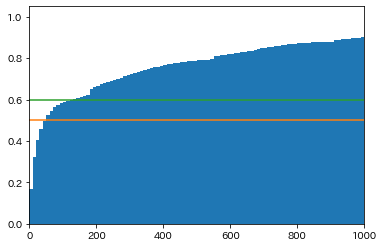

In [28]:
_date_max = int(df.days_no_review.max())
print(_date_max,_date_max/365)
plt.hist(df.days_no_review.dropna(),bins=range(0,_date_max,10),density=True,cumulative=True)
plt.plot(range(_date_max),[0.5 for i in range(_date_max)])
plt.plot(range(_date_max),[0.6 for i in range(_date_max)])
plt.xlim([0,1000])

In [29]:
del df['last_review']

# 各feature確認

In [30]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
days_no_review                    float64
dtype: object

In [31]:
#お部屋タイプ
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [32]:
#エリア
df.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [33]:
#地名
df.neighbourhood.unique()

array(['Kensington', 'Midtown', 'Harlem', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Greenpoint', 'Bushwick', 'Flatbush', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [34]:
df.price.describe(percentiles=[0.25,0.50,0.75,1.0])

count   48895.00
mean      152.72
std       240.15
min         0.00
25%        69.00
50%       106.00
75%       175.00
100%    10000.00
max     10000.00
Name: price, dtype: float64

### 地域vs部屋タイプ on #hostname
- 結局、地域とタイプは限定される
- heatmap では二極化して、各区分で同じ数くらいいるけど、それぞれで値段の帯域が違う。特にブルックリン

In [35]:
def cal_set(a):
    return len(set(a))/float(len(set(df.host_name)))

In [36]:
df.neighbourhood_group.value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [37]:
df.room_type.value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

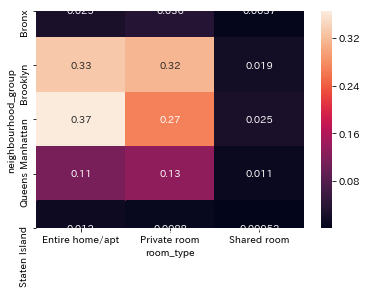

In [38]:
df_tmp = pd.pivot_table(df,index='neighbourhood_group',columns='room_type',values='host_name',aggfunc=cal_set)
sns.heatmap(data=df_tmp, annot=True)

### Price　on 地域 
- 地域ごとにpriceの差がある。
    - 外れ値を無視して考える。
        - 構成の観点からは、マンハッタン＞ブルックリン＞他
            - ブレイクダウンしても同様で、さらに顕著に出ている
        - 他のものであれば、Bronxが若干劣っている
    - 外れ値では、どの地域にも高い物件が存在する
    
- 以上から、ブレイクダウンした結果(結合)を用いることがベストであると思う

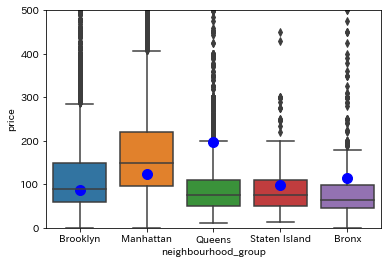

In [39]:
col = 'neighbourhood_group'
df_tmp_mean = df.groupby(col)['price'].mean()
plt.ylim([0,500])
ax = sns.boxplot(x=col,y='price',data=df)
for i, _label in enumerate(ax.get_xticklabels()):
    plt.plot(i,df_tmp_mean[i],marker='o', markersize=10,color='b')
# for _key in list(set(df[col])):
#     df_stat = df.loc[df[col] == _key].price.describe()

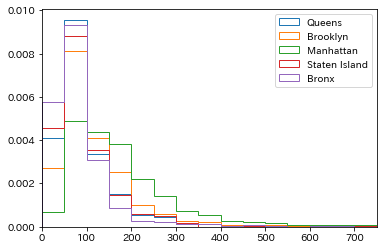

In [40]:
for i, _label in enumerate(set(df[col])):
    plt.hist(df[df[col]==_label]['price'],label=_label,bins=range(0,10000,50),density=True,alpha=1, histtype="step")
plt.xlim(0,750)
plt.legend()


In [41]:
ls_order_graph_tmp = [ _group+'-'+_type  for _type in set(df.room_type) for _group in set(df.neighbourhood_group)]

([<matplotlib.axis.XTick at 0x10ac06dd8>,
 <a list of 15 Text xticklabel objects>)

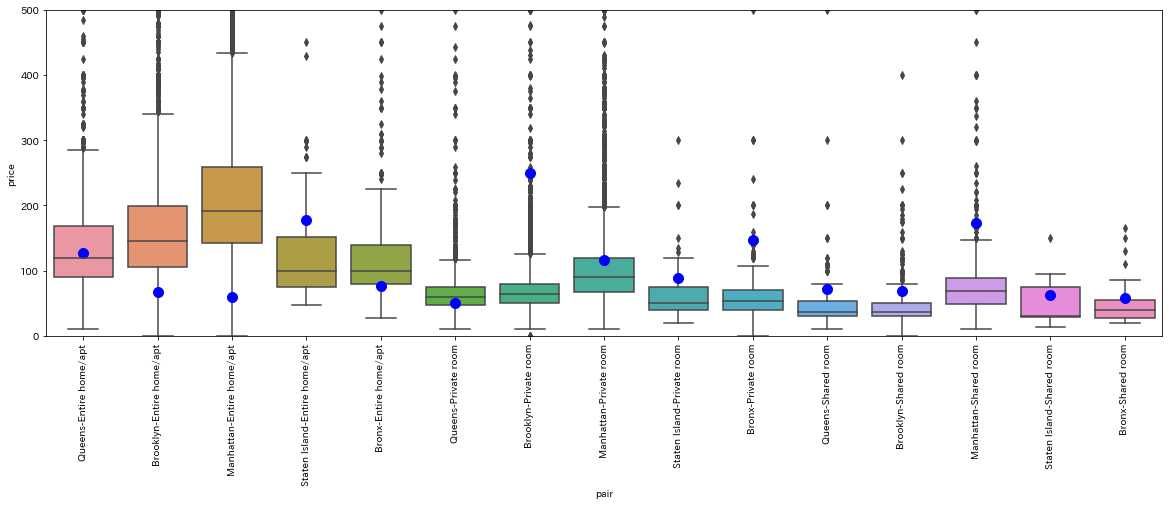

In [42]:
col = 'pair'
df['pair'] = df.neighbourhood_group + '-'+df.room_type
df_tmp_mean = df.groupby(col)['price'].mean()
fig = plt.figure(figsize=(20.0, 6.0))
plt.ylim([0,500])
ax = sns.boxplot(x=col,y='price',data=df,order=ls_order_graph_tmp)
for i, _label in enumerate(ax.get_xticklabels()):
    plt.plot(i,df_tmp_mean[i],marker='o', markersize=10,color='b')
# for _key in list(set(df[col])):
#     df_stat = df.loc[df[col] == _key].price.describe()
plt.xticks(range(len(ax.get_xticklabels())), ax.get_xticklabels(), rotation=90)

In [43]:
### 

### 場所ごと
- 場所に関してどの程度Hostが居るのか
    - 対数取るときれいに線形
        - 場所に関するメタ的な特性が無い
        - テキストとして処理することは問題がある。
- 歯科としてもいいと思う。

<BarContainer object of 221 artists>

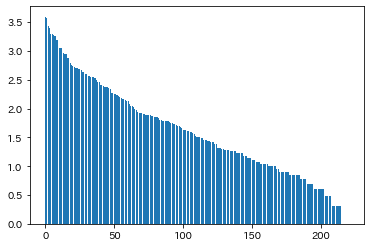

In [44]:
plt.bar(range(len(df.neighbourhood.value_counts())),np.log10(df.neighbourhood.value_counts().values))

In [45]:
df['neighbourhood_group-room_type'] = df.neighbourhood_group + '-' +df.room_type

## mim-stay vs price
- min-nightはそもそもログにしたほうがいいので、logにする。
- 少min-nightの方では、線形に減る傾向にある。
- priceが非常に高いhostを除外した場合、min-stayごとにpriceの分布は変わらない。
    - priceが非常に高いhostは減少傾向にはある。 

In [46]:
df.minimum_nights.describe()

count   48895.00
mean        7.03
std        20.51
min         1.00
25%         1.00
50%         3.00
75%         5.00
max      1250.00
Name: minimum_nights, dtype: float64

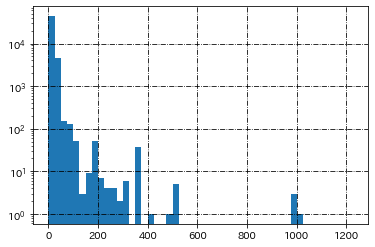

In [47]:

plt.grid(which='major',color='black',linestyle='-.')
plt.hist(df.minimum_nights,bins=range(0,1250,25))
# plt.grid(which='minor',color='black',linestyle='-.')
plt.yscale('log')

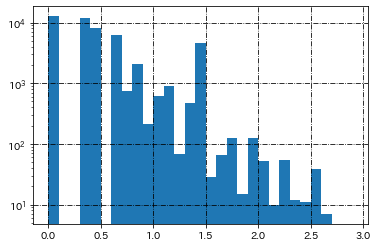

In [48]:
plt.hist(np.log10(df.minimum_nights),bins=[ i/1000.0 for i in range(0,3000,100)])
plt.grid(which='major',color='black',linestyle='-.')
# plt.grid(which='minor',color='black',linestyle='-.')
plt.yscale('log')

In [49]:
df['log_minimum_nights'] = np.log10(df.minimum_nights)

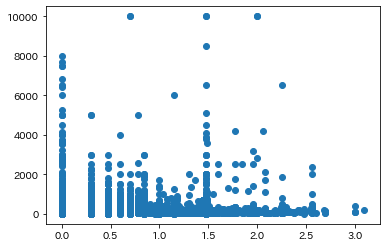

In [50]:
plt.scatter(df.log_minimum_nights,df.price)

In [51]:
ls_ctgr_log_night = [ i/10.0 for i in range(0,35,5)]
df['ctgr_log_minimum_nights'] = pd.cut(df.log_minimum_nights,bins=ls_ctgr_log_night)

(0, 500)

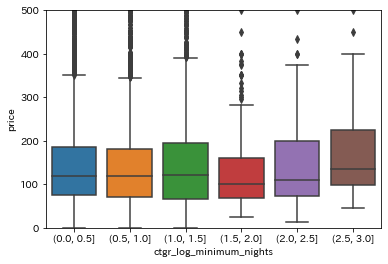

In [52]:
sns.boxplot(x='ctgr_log_minimum_nights',y='price',data=df)
plt.ylim(0,500)

### aviilable
- きれいに線形になっている。
- 但し、0が非常に多いので、0だけは区別する。Norevieｗの確信度を上げるため

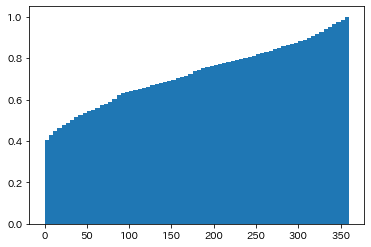

In [53]:
plt.hist(df.availability_365,bins=range(0,365,5),density=True,cumulative=True)
df['rate_availability'] = df.availability_365/365.0
df['no_availability'] = df.availability_365 == 0

### Nameを分析

In [54]:
df['lower_name'] = df.name.str.lower()

In [183]:
#短縮後辞書
shortened = {
    'w//':'with',
    '\'m': ' am',
    '\'re': ' are',
    'don\'t': 'do not',
    'doesn\'t': 'does not',
    'didn\'t': 'did not',
    'have\'t': 'have not',
    'won\'t': 'will not',
    'wanna': 'want to',
    'gonna': 'going to',
    'gotta': 'got to',
    'hafta': 'have to',
    'needa': 'need to',
    'outta': 'out of',
    'kinda': 'kind of',
    'sorta': 'sort of',
    'lotta': 'lot of',
    'lemme': 'let me',
    'gimme': 'give me',
    'getcha': 'get you',
    'gotcha': 'got you',
    'letcha': 'let you',
    'betcha': 'bet you',
    'shoulda': 'should have',
    'coulda': 'could have',
    'woulda': 'would have',
    'musta': 'must have',
    'mighta': 'might have',
    'dunno': 'do not know',
    'bdrm': 'bedroom',#カスタム
    'apt': 'apartment',#カスタム
    'apart': 'apartment',#カスタム
    'bed room': 'bedroom',#カスタム
    'nyc': 'newyork',#カスタム
    'new york': 'newyork',#カスタム
    'times square': 'timessquare',#カスタム
}


In [184]:
wnl = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = frozenset(stopwords.words('english'))
shortened_re = re.compile('(?:' + '|'.join(map(lambda x: '\\b' + x + '\\b', shortened.keys())) + ')')

In [185]:
def convert_text(sentence):
    sentence = shortened_re.sub(lambda x: shortened[x.group(0)], sentence)#短縮後を戻す(人工的に)
    sentence = (re.sub(r"[^\w']+"," ",sentence))
    sentence = (re.sub(r"[0-9]+"," ",sentence))
    sentence = nltk.word_tokenize(sentence)#単語分割
    sentence = list(filter(lambda x: x not in stop_words, sentence)) #stopwordを消す
    sentence = list(map(stemmer.stem, sentence)) #stemming　going->go
    sentence = list(map(wnl.lemmatize, sentence))#lemm stemmingとほぼ同じ。見出し語かしてくれるらしい。

    return sentence


In [186]:
df['lower_name_edited'] = df.lower_name.apply(lambda x: convert_text(x))

## Price vs HostName
- 各Hostnameを１つのDocument とみなす

- 文書作成

In [189]:
ls_ls_words = [_doc for _doc in df.lower_name_edited]
dictionary = gensim.corpora.Dictionary(ls_ls_words)
dictionary.filter_extremes(no_below=20, no_above=0.4)#float:ratio, imteger: count
corpus = [dictionary.doc2bow(ls_words) for ls_words in ls_ls_words]

In [190]:
#保存
dictionary.save('./tmp_data/words_dict.dict')
corpora.MmCorpus.serialize('./tmp_data/corpus.mm', corpus)

In [200]:
N_TOPIC = 5

In [201]:
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=N_TOPIC, id2word=dictionary)

In [202]:
for i_topic in range(N_TOPIC):
    ls_topic = lda.show_topic(i_topic)
    print("\n")
    print("="*80)
    for _topic in ls_topic:
        print("{0:20s}{1}".format(_topic[0], _topic[1]))



apart               0.04249733313918114
loft                0.037896715104579926
bushwick            0.03550775349140167
bright              0.02824527770280838
train               0.025343693792819977
view                0.024678463116288185
williamsburg        0.022996574640274048
jfk                 0.02247028425335884
's                  0.02123185060918331
br                  0.02066485956311226


apart               0.06520818173885345
bedroom             0.0639830157160759
manhattan           0.04493921622633934
midtown             0.028462428599596024
spaciou             0.028113974258303642
w                   0.02387101761996746
beauti              0.023434413596987724
room                0.023288197815418243
br                  0.02206011861562729
min                 0.018946204334497452


park                0.07281654328107834
central             0.05048808827996254
home                0.047410525381565094
apart               0.03807615861296654
studio              0.032

In [206]:
for i_topic in range(N_TOPIC):
    df['topic_'+str(i_topic)] = np.nan

In [ ]:
dictionary = corpora.Dictionary(texts)
dictionary.save('/tmp/deerwester.dict')

In [209]:
df_topic = pd.DataFrame({ i_row: { 'topic_'+str(_topic[0]) : _topic[1] for _topic in lda.get_document_topics(corpus[i_row]) } for i_row in range(len(df)) })
df_topic = df_topic.T

In [215]:
df = pd.concat([df,df_topic],axis=0)

/Users/macico/Dropbox/tanico_rikudo/deep/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## 楽しそうな図たち

## kaggleから引用したコード群
- 1. 

In [ ]:
import folium
from folium.plugins import MarkerCluster
from folium import plugins
print('Rooms with the most number of reviews')
Long=-73.80
Lat=40.80
mapdf1=folium.Map([Lat,Long],zoom_start=10,)

mapdf1_rooms_map=plugins.MarkerCluster().add_to(mapdf1)

for lat,lon,label in zip(df.latitude,df.longitude,df.name):
    folium.Marker(location=[lat,lon],icon=folium.Icon(icon='home'),popup=label).add_to(mapdf1_rooms_map)
mapdf1.add_child(mapdf1_rooms_map)

mapdf1

- 2. #営業日を地域ごとにプロットしてみた

In [ ]:
import urllib
#initializing the figure size
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)
#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()
#using scatterplot again
df.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.show()

### 実際に予測してみる

https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations#SUMMARY

In [245]:
df[[  'availability_365', 'calculated_host_listings_count',
              'ctgr_log_minimum_nights',                 'days_no_review',
                                                  'latitude',
                   'log_minimum_nights',                      'longitude',
                       'minimum_nights',                           
                                    'neighbourhood_group',
        'neighbourhood_group-room_type',                'no_availability',
                    'number_of_reviews',                          
                                'price',              'rate_availability',
                    'reviews_per_month',                      'room_type',
                                                        'topic_0',
                              'topic_1',                        'topic_2',
                              'topic_3',                        'topic_4']]

,availability_365,calculated_host_listings_count,ctgr_log_minimum_nights,days_no_review,latitude,log_minimum_nights,longitude,minimum_nights,neighbourhood_group,neighbourhood_group-room_type,...,number_of_reviews,price,rate_availability,reviews_per_month,room_type,topic_0,topic_1,topic_2,topic_3,topic_4
0,365.00,6.00,NaN,262.00,40.65,0.00,-73.97,1.00,Brooklyn,Brooklyn-Private room,...,9.00,149.00,1.00,0.21,Private room,0.03,0.25,0.65,0.03,0.03
1,355.00,2.00,NaN,48.00,40.75,0.00,-73.98,1.00,Manhattan,Manhattan-Entire home/apt,...,45.00,225.00,0.97,0.38,Entire home/apt,0.10,0.60,0.10,0.10,0.10
2,365.00,1.00,"(0.0, 0.5]",nan,40.81,0.48,-73.94,3.00,Manhattan,Manhattan-Private room,...,0.00,150.00,1.00,0.00,Private room,0.05,0.05,0.38,0.05,0.47
3,194.00,1.00,NaN,3.00,40.69,0.00,-73.96,1.00,Brooklyn,Brooklyn-Entire home/apt,...,270.00,89.00,0.53,4.64,Entire home/apt,0.56,0.04,0.04,0.04,0.32
4,0.00,1.00,"(0.5, 1.0]",231.00,40.80,1.00,-73.94,10.00,Manhattan,Manhattan-Entire home/apt,...,9.00,80.00,0.00,0.10,Entire home/apt,0.41,0.03,0.51,0.03,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,nan,nan,NaN,nan,nan,nan,nan,nan,NaN,NaN,...,nan,nan,nan,nan,NaN,0.03,0.86,0.03,0.03,0.04
48891,nan,nan,NaN,nan,nan,nan,nan,nan,NaN,NaN,...,nan,nan,nan,nan,NaN,0.25,0.03,0.03,0.48,0.20
48892,nan,nan,NaN,nan,nan,nan,nan,nan,NaN,NaN,...,nan,nan,nan,nan,NaN,0.04,0.48,0.40,0.04,0.04
48893,nan,nan,NaN,nan,nan,nan,nan,nan,NaN,NaN,...,nan,nan,nan,nan,NaN,0.28,0.03,0.03,0.48,0.19


In [228]:
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, Xlv_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [229]:
# for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, HuberRegressor]:
    cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

NameError: name 'numerical_features' is not defined

In [ ]:
alphas1 = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]

In [ ]:
alphas2 = [0.5*i for i in range(4,12)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]

In [ ]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots(1,2,figsize=(21, 8))
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[0]) 
axes[0].set_xlabel("alpha") 
axes[0].set_ylabel("rmse")
axes[0].set_xscale('log')

cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes[1]) 
axes[1].set_xlabel("alpha") 
axes[1].set_ylabel("rmse")
axes[1].set_xscale('log')

#RR_best = Ridge(alpha = np.argmin(cv_ridge)) RR_best.fit(X_train, y_train) predicted_prices = RR_best.predict(test_data)

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas1,
        y= cv_ridge1,
        line = dict(color='royalBlue', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            )
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Coarse level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = alphas2,
        y= cv_ridge2,
        line = dict(color='crimson', width=2)
        ),
)



fig.update_layout(
   
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Penalty",
            font=dict(
                size=16
            )
        )
    ),
    
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Cross-validation error",
            font=dict(
                size=16
            ),
        )
    ),
)


fig.update_layout(height=400,
                width = 600,
                title = 'Telescopic Search: Fine level', 
                  xaxis_type="log", 
                  showlegend=False)

fig.show()


In [ ]:
best_alpha = alphas2[np.argmin(cv_ridge2.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

In [225]:

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

# from xgboost import XGBRegressor

#Model interpretation modules
import eli5
import lime
import lime.lime_tabular
import shap
shap.initjs()

In [ ]:
xplainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_df.columns, class_names=['price'], verbose=True, mode='regression')